In [1]:
import env
import utilities as utils
import wrangle as w

# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler


In [2]:
sql = '''
        SELECT *
        FROM grocery_customers;
      '''

In [3]:
url = utils.generate_db_url(env.user, env.password, env.host, 'grocery_db')

In [4]:
df = utils.generate_df('grocery.csv', query=sql, db_url=url, cached=True)

In [5]:
df.set_index(df.customer_id, drop=False, inplace=True)

In [6]:
# df.drop(columns='customer_id', inplace=True)
# df.drop(["Channel", "Region"], axis = 1, inplace = True)

In [7]:
df.columns = df.columns.str.lower()

In [8]:
df.rename(columns={'delicassen':'deli'}, inplace=True)

In [9]:
df.head()

,customer_id,channel,region,fresh,milk,grocery,frozen,detergents_paper,deli
customer_id,,,,,,,,,
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185


In [10]:
df = df[["deli", "frozen","detergents_paper"]]

In [11]:
np_array = df.values.astype('float32', copy=False)
np_array

array([[ 1338.,   214.,  2674.],
       [ 1776.,  1762.,  3293.],
       [ 7844.,  2405.,  3516.],
       ...,
       [ 1867.,   437., 14841.],
       [ 2125.,  1038.,   168.],
       [   52.,    65.,   477.]], dtype=float32)

In [12]:
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array

array([[0.02784731, 0.0031063 , 0.0654272 ],
       [0.03698373, 0.02854842, 0.08058985],
       [0.16355862, 0.03911643, 0.08605233],
       ...,
       [0.03888194, 0.00677142, 0.36346266],
       [0.04426366, 0.01664914, 0.00404174],
       [0.00102211, 0.00065742, 0.01161082]], dtype=float32)

In [13]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [14]:
dbsc = DBSCAN(eps = .05, min_samples = 5).fit(np_array)

In [15]:
labels = dbsc.labels_
labels[0:10]

array([ 0,  0, -1,  0,  0,  0,  0,  0,  0,  0])

In [16]:
df['labels'] = labels
df.labels.value_counts()

 0    403
-1     23
 1     14
Name: labels, dtype: int64

In [17]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(df.describe())
print("-------------")
print("Large Inliers")
print(df[df.labels==0].describe())
print("-------------")
print("Small Inliers")
print(df[df.labels==1].describe())
print("-------------")
print("Outliers")
print(df[df.labels==-1].describe())

Population
               deli        frozen  detergents_paper  Scaled_deli  \
count    440.000000    440.000000        440.000000   440.000000   
mean    1524.870455   3071.931818       2881.493182     0.031745   
std     2820.105937   4854.673333       4767.854448     0.058826   
min        3.000000     25.000000          3.000000     0.000000   
25%      408.250000    742.250000        256.750000     0.008453   
50%      965.500000   1526.000000        816.500000     0.020077   
75%     1820.250000   3554.250000       3922.000000     0.037907   
max    47943.000000  60869.000000      40827.000000     1.000000   

       Scaled_frozen  Scaled_detergents_paper      labels  
count     440.000000               440.000000  440.000000  
mean        0.050078                 0.070510   -0.020455  
std         0.079789                 0.116790    0.289591  
min         0.000000                 0.000000   -1.000000  
25%         0.011788                 0.006216    0.000000  
50%         0.02

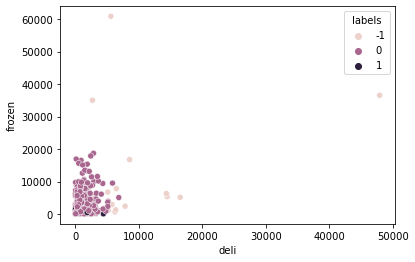

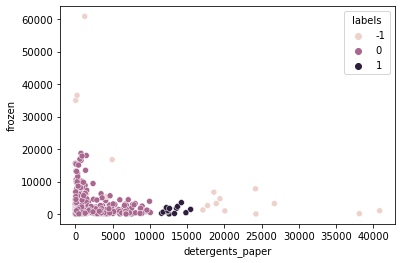

In [18]:
sns.scatterplot(df.deli, df.frozen, hue=df.labels)
plt.show()

sns.scatterplot(df.detergents_paper, df.frozen, hue=df.labels)
plt.show()

Text(0.5, 0, 'Detergents and Paper Products')

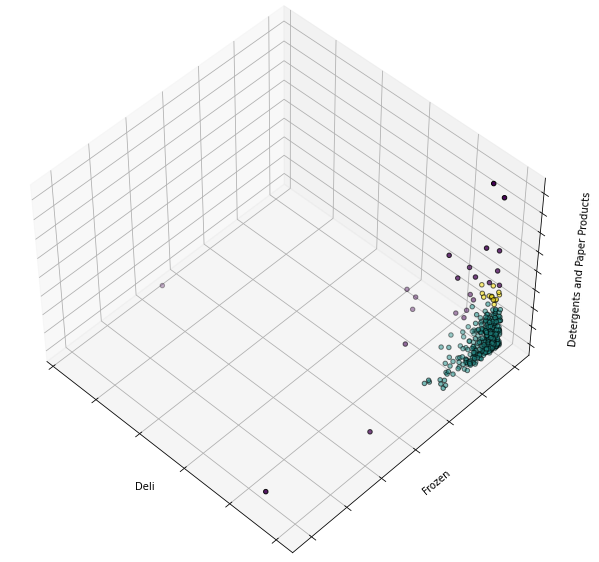

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.deli, df.frozen, df.detergents_paper,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Deli')
ax.set_ylabel('Frozen')
ax.set_zlabel('Detergents and Paper Products')

# Zillow

In [36]:
df = pd.read_csv('/Users/matthewdalton/projects/zillow-clustering-project/wrangled_zillow.csv')

In [37]:
df.head()

,parcelid,heating_system_type_id,bathrooms,bedrooms,prop_sqft,fips,fireplace_cnt,latitude,longitude,lot_sqft,...,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
0,10711855,2,2.0,3.0,2107.0,6037,0.0,0.342226,-1.186174,9158,...,1.227188,0.210239,0.2,0.5,118.488372,0.4,40.891461,0.3,0.666667,1
1,10711877,2,2.0,4.0,1882.0,6037,0.0,0.342203,-1.186164,9035,...,1.230895,0.207415,0.2,0.4,134.431456,0.4,45.047039,0.3,0.500000,1
2,10711888,2,2.0,4.0,1882.0,6037,0.0,0.342225,-1.186169,9800,...,1.229132,0.224977,0.2,0.4,136.870882,0.4,29.115510,0.3,0.500000,1
3,10711910,2,2.0,3.0,1477.0,6037,0.0,0.342219,-1.186157,11285,...,1.430790,0.259068,0.3,0.3,39.247123,0.1,1.777847,0.1,0.666667,1
4,10711923,2,2.0,4.0,1918.0,6037,0.0,0.342206,-1.186153,11239,...,1.261220,0.258012,0.3,0.4,87.522941,0.3,22.029540,0.3,0.500000,1


In [38]:
df = df[['bathrooms','prop_sqft','latitude','log_error']]

In [39]:
np_array = df.values.astype('float32', copy=False)
np_array

array([[ 2.0000000e+00,  2.1070000e+03,  3.4222558e-01, -7.3572891e-03],
       [ 2.0000000e+00,  1.8820000e+03,  3.4220260e-01,  2.1066284e-02],
       [ 2.0000000e+00,  1.8820000e+03,  3.4222490e-01,  7.7174455e-02],
       ...,
       [ 3.0000000e+00,  2.1080000e+03,  3.4126076e-01, -1.5870062e-01],
       [ 4.0000000e+00,  2.2300000e+03,  3.3850801e-01, -1.7579973e-02],
       [ 4.0000000e+00,  4.2320000e+03,  3.3981299e-01,  1.9842247e-02]],
      dtype=float32)

In [40]:
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array

array([[0.11111111, 0.20214504, 0.6275749 , 0.59353834],
       [0.11111111, 0.17916241, 0.62594223, 0.5971679 ],
       [0.11111111, 0.17916241, 0.6275253 , 0.6043327 ],
       ...,
       [0.22222224, 0.20224719, 0.55900383, 0.57421243],
       [0.33333334, 0.21470888, 0.36336517, 0.59223294],
       [0.33333334, 0.41920325, 0.4561119 , 0.5970116 ]], dtype=float32)

In [41]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [50]:
dbsc = DBSCAN(eps = .1, min_samples = 100).fit(np_array)

In [51]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [52]:
df['labels'] = labels
df.labels.value_counts()

 0    59927
-1      313
Name: labels, dtype: int64

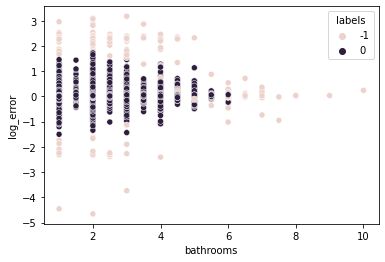

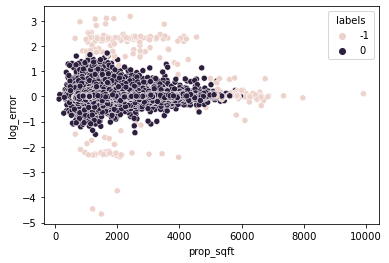

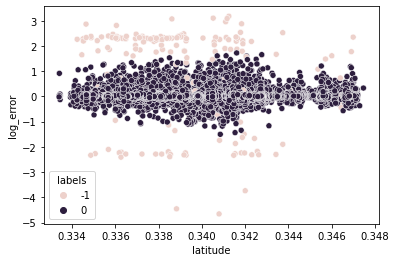

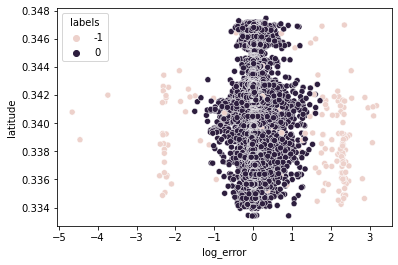

In [53]:
'bathrooms','prop_sqft','latitude','log_error'


sns.scatterplot(df.bathrooms, df.log_error, hue=df.labels)
plt.show()

sns.scatterplot(df.prop_sqft, df.log_error, hue=df.labels)
plt.show()

sns.scatterplot(df.latitude, df.log_error, hue=df.labels)
plt.show()

sns.scatterplot(df.log_error, df.latitude, hue=df.labels)
plt.show()


In [54]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(df.describe())
print("-------------")
print("Group 0")
print(df[df.labels==0].describe())
print("-------------")
print("Group 1")
print(df[df.labels==1].describe())
print("-------------")
print("Group 2")
print(df[df.labels==2].describe())
print("-------------")
print("Outliers")
print(df[df.labels==-1].describe())
print("-------------")

Population
          bathrooms     prop_sqft      latitude     log_error  \
count  60240.000000  60240.000000  60240.000000  60240.000000   
mean       2.211006   1724.889077      0.340017      0.017218   
std        0.845096    756.115993      0.002702      0.163507   
min        1.000000    128.000000      0.333395     -4.655420   
25%        2.000000   1203.000000      0.338024     -0.023414   
50%        2.000000   1541.000000      0.340041      0.006598   
75%        3.000000   2064.000000      0.341769      0.038132   
max       10.000000   9918.000000      0.347466      3.175688   

       Scaled_bathrooms  Scaled_prop_sqft  Scaled_latitude  Scaled_log_error  \
count      60240.000000      60240.000000     60240.000000      60240.000000   
mean           0.134565          0.163116         0.470616          0.596674   
std            0.093904          0.077234         0.192059          0.020879   
min            0.000000          0.000000         0.000000          0.000000   
25%

# Access Logs

In [55]:
df = w.wrangle_logs()

In [56]:
df.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,program_id,php,java,ds,front
date,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,1,0,0,0
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,1,0,0,0
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,1,0,0,0
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,1,0,0,0
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2,0,1,0,0


In [63]:
df = df[['user_id', 'cohort_id','end_date']]

In [65]:
df.shape

(900223, 3)

In [68]:
dbsc = DBSCAN(eps = .5, min_samples = 100).fit(df)

TypeError: invalid type promotion

In [58]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [59]:
df['labels'] = labels
df.labels.value_counts()

ValueError: Length of values (60240) does not match length of index (900223)